<a href="https://colab.research.google.com/github/Gus-1003/ISD_psb20232/blob/main/Pratica/Aula_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de um sinal de EMG

## Baixando os dados:

In [30]:
# Se offline, comentar esta célula
!gdown '1pjfYQR1r0OxwnxjW1VktjWouzJeP8Hbt'

Downloading...
From: https://drive.google.com/uc?id=1pjfYQR1r0OxwnxjW1VktjWouzJeP8Hbt
To: /content/EMG_example.csv
100% 9.48M/9.48M [00:00<00:00, 202MB/s]


In [31]:
#@title Bibliotecas e módulos necessários

import numpy as np # Álgebra
import pandas as pd # Manipulação de dados
import matplotlib.pyplot as plt # Visualização de dados

from scipy.signal import butter,cheby1,bessel,ellip,iirnotch,filtfilt # Filtros
from scipy.signal import welch # PSD do sinal

Este arquivo .csv contém os dados crus de EMG de uma coleta feita semestre passado. A coleta foi feita utilizando um V-Amp de 2 canais e o dataset original também tem 16 canais de EEG, mas vamos ficar apenas no EMG por agora.

**[Pergunta:] o que o parâmetro *sep* nos diz sobre o arquivo carregado?**

R.: Character or regex pattern to treat as the delimiter.

## Análise Exploratoria:

In [32]:
df_EMG = pd.read_csv('EMG_example.csv', sep=';')
df_EMG

,time[s],EMG 1,EMG 2,Event id
0,0.000000,-43454.152344,-24474.855469,RL
1,0.001953,-43479.835938,-24485.597656,NaN
2,0.003906,-43466.605469,-24482.277344,NaN
3,0.005859,-43462.601562,-24485.451172,NaN
4,0.007812,-43460.988281,-24488.380859,NaN
...,...,...,...,...
196283,383.365234,5079.980957,-3897.900635,NaN
196284,383.367188,5086.914551,-3877.002197,NaN
196285,383.369141,5075.391113,-3879.541260,NaN
196286,383.371094,5075.732910,-3876.611572,NaN


In [33]:
df_EMG.head()

,time[s],EMG 1,EMG 2,Event id
0,0.000000,-43454.152344,-24474.855469,RL
1,0.001953,-43479.835938,-24485.597656,NaN
2,0.003906,-43466.605469,-24482.277344,NaN
3,0.005859,-43462.601562,-24485.451172,NaN
4,0.007812,-43460.988281,-24488.380859,NaN


Como podem ver, o arquivo tem uma coluna de instante da amostra, 2 canais de EMG e uma coluna indicando eventos relacionados a coleta. Neste caso, os eventos são relacionados ao acionamento de um áudio indicando com qual pé começar um ciclo de marcha e se o ciclo deveria ser utilizando passos curtos ou longos.

Podemos ver a lista completa de todos os valores contidos em *Event id*
 selecionando esta coluna (que agora é uma série por ser uma única coluna) e utilizando a função [*unique()*](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html). Os valores numéricos não foram relevantes para o estudo (e nem serão para nós).

In [34]:
df_EMG['Event id'].unique()

array(['RL', nan, 'Gait begin', 'Gait end', 'RS', 'LL', 'LS', '1010',
       '33281'], dtype=object)

A frequência de amostragem do V-Amp é de 512 Hz, então vamos salvar isso em uma variável com o nome muito criativo de *fs*

---

**[Exercício:] é possível obter o valor da frequência de amostragem diretamente da coluna *time[s]*. (Isso foi uma afirmação)**



**Tente fazer isso. Caso esteja com muita dificuldade, os seguintes métodos podem te ajudar:**


*   **[diff](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html)**
*   **[mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html)**




## Aprendendo sobre Sinais:

### Frequência:

In [35]:
# Calcule o período de amostragem
periodo_amostragem = df_EMG['time[s]'][1] - df_EMG['time[s]'][0]

# Calcule a frequência de amostragem
fs = 1 / periodo_amostragem

print("Frequência de Amostragem (Hz):", fs)

Frequência de Amostragem (Hz): 512.0


In [36]:
fs = 512

Com a frequência de amostragem salva numa variável, vamos repetir o processo salvando cada coluna em uma variável, mas convertendo antes a coluna de *Series* (coluna do pandas) para *numpy array* (vetor do numpy).

No caso dos sinais de EMG, também foi adicionado a eles um ruído artificial para podermos visualizar a interferência do ruído no sinal.

### Fabricação de um Ruido Artificial:

In [37]:
time = df_EMG['time[s]'].to_numpy()
time

array([0.00000000e+00, 1.95312500e-03, 3.90625000e-03, ...,
       3.83369141e+02, 3.83371094e+02, 3.83373047e+02])

In [46]:
time = df_EMG['time[s]'].to_numpy()

freq_noise = 60 # Frequência do ruído artificial

artificial_noise = 5000*np.sin(2*np.pi*freq_noise*time) # Ruído artificial sendo
                                                        # apenas uma senóide


# Aplicação do ruido ao decorrer dos valores das colunas EMG 1 e EMG 2
emg1 = df_EMG['EMG 1'].to_numpy()+artificial_noise
emg2 = df_EMG['EMG 2'].to_numpy()+artificial_noise

# Vetor dos Eventos que ocorreram ao decorrer do tempo
events = df_EMG['Event id'].to_numpy()
events

array(['RL', nan, nan, ..., nan, nan, nan], dtype=object)

In [47]:
artificial_noise

array([   0.        , 3357.79477424, 4975.92363336, ..., 4016.03765732,
       4975.92363337, 3357.79477433])

### Busca por um Evento Especifico:

Caso venha a ser necessário selecionar apenas algum tipo de evento, podemos fazer isso utilizando a função [*argwhere*](https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html) do [*numpy*](https://numpy.org/doc/stable/index.html)

array(['RL', nan, 'Gait begin', 'Gait end', 'RS', 'LL', 'LS', '1010',
       '33281'], dtype=object)

In [48]:
specific_event = np.argwhere(events=='RS')[:,0] # Selecionando a primeira coluna
                                                # para termos o vetor dos indices


specific_event = specific_event/fs  # Converter o indice para tempo
print(specific_event)

[  7.5  23.5  41.5  77.5 144.5 177.5 186.  275.5 284.  327.5 373. ]


### Tipos de Filtros (Funções):

Por praticidade, já foram criadas as funções de aplicações de filtro logo abaixo. As funções criadas e os parâmetros estritamente necessários são:



*   low_filter(signal,N,fc,Fs)
*   high_filter(signal,N,fc,Fs)
*   bandpass_filter(signal,N,f_low,f_high)
*   bandstop_filter(signal,N,f_low,f_high)
*   notch_filter(signal,Fs)



In [41]:
def low_filter(signal, N,fc,Fs,filter_type='butter',max_ripple=3):
  """
  Entradas
  -signal: array do sinal no formato [tempo,]
  -N: ordem do filtro
  -fc: frequência de corte do filtro
  -Fs: frequência de amostragem
  -filter_type: tipo do filtro (butterworth, chebyshev, elíptico ou bessel)
  -max_ripple: ripple máximo para os filtros chebyshev e elípticos

  Saídas
  -filtered: array do sinal filtrado no formato [tempo,]
  """
  match filter_type:
    case 'butter':
      b,a = butter(N,fc,'low',fs=Fs)
    case 'cheby':
      b,a = cheby1(N,max_ripple,fc,'low',fs=Fs)
    case 'bessel':
      b,a = bessel(N,fc,'low',fs=Fs,norm='mag')
    case 'ellip':
      b,a = ellip(N,max_ripple,max_ripple,fc,'low',fs=Fs)

  filtered = filtfilt(b,a,signal,padlen=16)
  return filtered

def high_filter(signal,N,fc,Fs,filter_type='butter',max_ripple=3):
  """
  Entradas
  -signal: array do sinal no formato [tempo,]
  -N: ordem do filtro
  -fc: frequência de corte do filtro
  -Fs: frequência de amostragem
  -filter_type: tipo do filtro (butterworth, chebyshev, elíptico ou bessel)
  -max_ripple: ripple máximo para os filtros chebyshev e elípticos

  Saídas
  -filtered: array do sinal filtrado no formato [tempo,]
  """
  match filter_type:
    case 'butter':
      b,a = butter(N,fc,'high',fs=Fs)
    case 'cheby':
      b,a = cheby1(N,max_ripple,fc,'high',fs=Fs)
    case 'bessel':
      b,a = bessel(N,fc,'high',fs=Fs,norm='mag')
    case 'ellip':
      b,a = ellip(N,max_ripple,max_ripple,fc,'high',fs=Fs)

  filtered = filtfilt(b,a,signal,padlen=16)
  return filtered

def bandpass_filter(signal,N,f_low,f_high,Fs,filter_type='butter',max_ripple=3):
  """
  Entradas
  -signal: array do sinal no formato [tempo,]
  -N: ordem do filtro
  -f_low: frequência mínima do passa-banda
  -f_high: frequência máxima do passa-banda
  -Fs: frequência de amostragem
  -filter_type: tipo do filtro (butterworth, chebyshev, elíptico ou bessel)
  -max_ripple: ripple máximo para os filtros chebyshev e elípticos

  Saídas
  -filtered: array do sinal filtrado no formato [tempo,]
  """
  match filter_type:
    case 'butter':
      b,a = butter(N,[f_low,f_high],'bandpass',fs=Fs)
    case 'cheby':
      b,a = cheby1(N,max_ripple,[f_low,f_high],'bandpass',fs=Fs)
    case 'bessel':
      b,a = bessel(N,[f_low,f_high],'bandpass',fs=Fs,norm='mag')
    case 'ellip':
      b,a = ellip(N,max_ripple,max_ripple,[f_low,f_high],'bandpass',fs=Fs)

  filtered = filtfilt(b,a,signal,padlen=16)
  return filtered

def bandstop_filter(signal,N,f_low,f_high,Fs,filter_type='butter',f_notch=60,Q=30,max_ripple=3):
  """
  Entradas
  -signal: array do sinal no formato [tempo,]
  -N: ordem do filtro
  -f_low: frequência mínima do rejeita-banda
  -f_high: frequência máxima do rejeita-banda
  -Fs: frequência de amostragem
  -filter_type: tipo do filtro (butterworth, chebyshev, elíptico ou bessel)
  -max_ripple: ripple máximo para os filtros chebyshev e elípticos

  Saídas
  -filtered: array do sinal filtrado no formato [tempo,]
  """
  match filter_type:
    case 'butter':
      b,a = butter(N,[f_low,f_high],'bandstop',fs=Fs)
    case 'cheby':
      b,a = cheby1(N,max_ripple,[f_low,f_high],'bandstop',fs=Fs)
    case 'bessel':
      b,a = bessel(N,[f_low,f_high],'bandstop',fs=Fs,norm='mag')
    case 'ellip':
      b,a = ellip(N,max_ripple,max_ripple,[f_low,f_high],'bandstop',fs=Fs)

  filtered = filtfilt(b,a,signal,padlen=16)
  return filtered


def notch_filter(signal,Fs,Q=20,fc=60):
  """
  Entradas
  -signal: array do sinal no formato [tempo,]
  -Q: fator de qualidade do filtro notch
  -Fs: frequência de amostragem
  -fc: frequência de corte do filtro

  Saídas
  -filtered: array do sinal filtrado no formato [tempo,]
  """
  b,a = iirnotch(fc,Q,Fs)
  filtered = filtfilt(b,a,signal,padlen=16)
  return filtered


def psd_plot(signal,Fs,f_min=.5,f_max=400):
  """
  Entradas
  -signal: array do sinal no formato [tempo,]
  -N: ordem do filtro
  -Fs: frequência de amostragem
  -f_min: menor frequência a ser visualizada
  -f_max: maior frequência a ser visualizada

  Saídas
  -Plot da PSD do sinal
  """
  freq_psd, original_psd = welch(signal,Fs) # Calcula PSD usando método de
                                            # Welch

  idx_min = np.where(freq_psd>f_min)[0][0]
  idx_max = np.where(freq_psd<f_max)[0][-1]

  plt.plot(freq_psd[idx_min:idx_max],original_psd[idx_min:idx_max])
  plt.xlabel('Frequency [Hz]')
  plt.ylabel('Power [V²/Hz]')


### Imputs necessarios para a pratica:

Abaixo já estão os parâmetros que são estritamente necessários e o que eles significam

In [42]:
# Parâmetros
N = 4 # Ordem dos filtros
fc = 200 # Frequência de corte
freq_low = 20 # Frequência mínima da banda
freq_high = 200 # Frequência máxima da banda

Aqui é como se aplica as funções acima. Neste exemplo foi aplicado um passa-banda bem padrão de EMG (N=4, banda de passagem: 20-200 Hz). Mas experimente alterar o tipo de filtro e os parâmetros que geralmente já possuem um valor definido.

---

**[Pergunta:] por que utilizamos uma frequência máxima de banda de passagem como sendo 200 Hz ao invés de 500 Hz, como foi apresentado em aula?**

### Filtros Base:

In [43]:
emg_filtered = bandpass_filter(emg1,N=N,f_low=freq_low,f_high=freq_high,Fs=fs)


emg_filtered = notch_filter(emg_filtered,Fs=fs)

## Visualização Gráfica:

Agora que temos o sinal filtrado, vamos visualizar como o sinal ficou tanto no domínio do tempo quanto no da frequência. Para visualização no domínio da frequência, só precisa utilizar a função *psd_plot()* que ela já calcula a [PSD](https://en.wikipedia.org/wiki/Spectral_density)

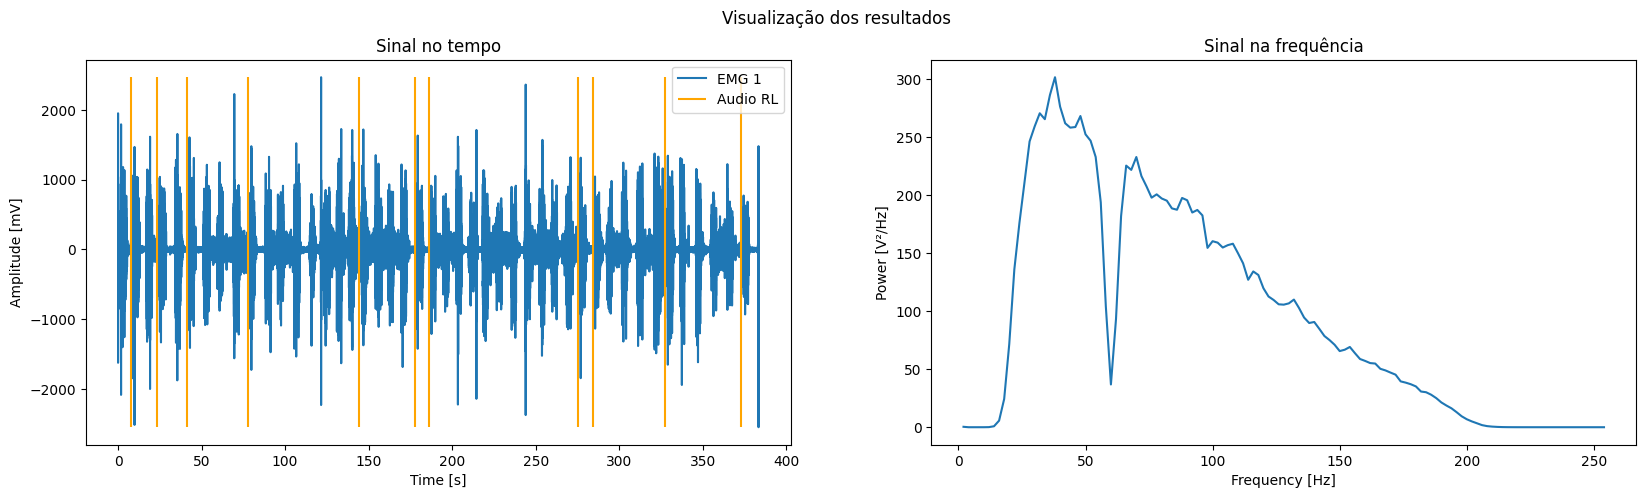

In [44]:
plt.figure(figsize=(20,5))
plt.suptitle('Visualização dos resultados')

plt.subplot(121)
plt.plot(time,emg_filtered, label='EMG 1')
plt.vlines(specific_event, ymin=emg_filtered.min(),
           ymax=emg_filtered.max(), label='Audio RL',
           color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title('Sinal no tempo')
plt.legend()

plt.subplot(122)
psd_plot(emg_filtered,Fs=fs)
plt.title('Sinal na frequência')

plt.show()

# Exercícios extras

**Resolva os exercícios criando células de código dentro desta seção**

Aqui alguns exercícios para exercitar a lógica de processamento de dados. Eles são opcionais, mas é altamente recomendado tentar resolver (e isso pode ajudar na consideração no momento de correção da prova).

Tente resolver estes exercícios sem pedir ajuda, mas caso não consiga, sinta-se livrar para enviar mensagem para os monitores e a pedir ajuda com isso durante as monitorias

*   Selecionar apenas os segmentos referentes a marcha e filtrar o segmento médio
*   Selecionar apenas os segmentos referentes a marcha, elevar ao quadrado e filtrar o segmento quadrático médio
*   Tirar a raiz quadrada do segmento quadrático médio, obtendo o segmento RMS
*   Passar o RMS por um filtro passa baixa de 2ª ordem e com frequência de corte de 6 Hz
*   Plotar o resultado do filtro passa baixa junto do segmento médio original
*   Explicar o que você obteve


Sugestões de funções:  [*np.mean()*](https://numpy.org/doc/stable/reference/generated/numpy.mean.html); [*np.square()*](https://numpy.org/doc/stable/reference/generated/numpy.square.html); [*np.sqrt()*](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html)





